add in odds ratios http://www.theanalysisfactor.com/why-use-odds-ratios/
http://www.holehouse.org/mlclass/06_Logistic_Regression.html

# Python lab for logistic regression

Chapter 4 of Introduction to Statistical Learning is what you've used to understand the basics of logistic regression. At the end of the chapter, there is an R laboratory session using market data to illustrate the application of logistic regression... here we're going to be replicating that exercise in our language of choice, Python.

Because: Python > R

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression

Let's start by importing the Smarket data and having a look at the first few rows. You should be familiar with Stock Market data from the previous sprint... 

In [6]:
Smarket = pd.read_csv('Smarket/Smarket.csv')
pd.DataFrame.head(Smarket)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


As noted in ISLR, each row consists of a trading day, reflecting the year, the lagged return from each of the previos five trading days (```Lag1``` to ```Lag5```), the trading volume on the day (the number of shares traded on the day, measured in billions), the return on that day (```Today```) and a directional indicator, either Up for positive returns or Down for negative returns.

Next in the ISLR laboratory session, the correlation coefficients between different variables in the data frame are calculated. You may be interested to note how a manual adjustment is necessary in R to exclude the categorical variable ```Direction```, whereas the Pandas ```corr``` command excludes it automatically. (Then again, you may not be interested...).

In [7]:
pd.DataFrame.corr(Smarket)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


Lets make it a little easier to get insights from all of these numbers

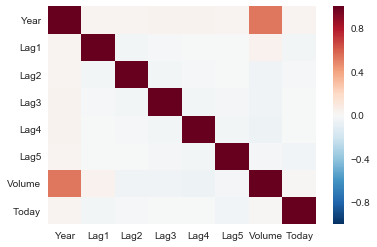

In [9]:
sns.heatmap(pd.DataFrame.corr(Smarket))

The correlation coefficients between the lagged returns and today's return are low in absolute terms, close to zero. This is consistent with the idea of efficient markets in finance: if prices embody all relevant information, then there should be no predictive value in past returns. The only meaningful correlation is between ```Year``` and ```Volume```, with trading volume increasing over time. Let's plot that to show the trend:

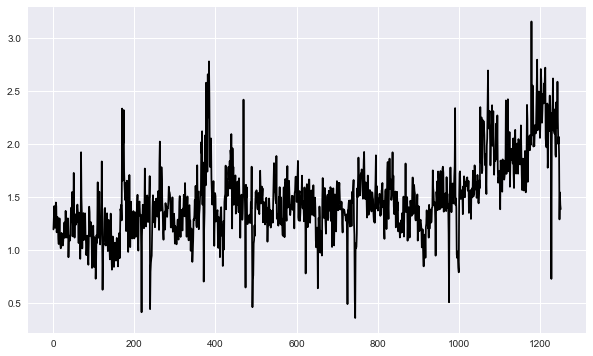

In [10]:
x = np.arange(1,len(Smarket[['Volume']])+1)

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x,Smarket[['Volume']],'k')
plt.show()

OK, what we've all been waiting for: logistic regression time :)

So our aim here is to predict `Direction`, a binary categorical variable, using the lagged returns as well as trading volume. Above we've imported the SciKit Learn function `LogisticRegression`, so let's dive right in:


In [11]:
X = np.array(Smarket[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']])  # needs to be array
y = np.ravel(Smarket[['Direction']])                                  # needs to be 1D array

model = LogisticRegression(solver='newton-cg')
model = model.fit(X, y)
print(model.intercept_, model.coef_)

[-0.12107884] [[-0.07284382 -0.04223527  0.0110161   0.00928364  0.01026345  0.13210837]]


So we don't get quite the same results for the coefficients as the textbook, but they're reasonably close (the technical reasons for the differences are beyond our scope at this stage). And the SciKit Learn function doesn't give us standard errors or p-values.

An alternative approach, more closely related to the approach taken in R, makes use of the ```glm``` function from the ```statsmodels``` library. (Shout out here to jcrouser, whose GitHub repository houses code very similar to what is shown below.)

In [ ]:
!conda install statsmodels

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm(formula = 'Direction ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume',
                data = Smarket, 
                family=sm.families.Binomial())
model = model.fit()
print(model.summary())

Those look much closer to the ISLR results, so let's use the data to predict the probability of the first ten observations. (Note that ```.predict``` by default takes the data used to fit the model.)

In [230]:
model.predict()[1:10]


array([ 0.51853212,  0.51886117,  0.48477764,  0.48921884,  0.49304354,
        0.50734913,  0.49077084,  0.48238647,  0.51116222])

Woah, those don't look like the ISLR results! But wait a moment, there is a relationship... Note that R encoded an Up movement as a 1, whereas if we have a look at the first ten directional observations and the way that Python has encoded them, it's clear that Python has decided that Down is a 1.

In [231]:
print(Smarket[['Direction']][1:10])
print(model.model.endog[1:10])

  Direction
1        Up
2      Down
3        Up
4        Up
5        Up
6      Down
7        Up
8        Up
9        Up
[ 0.  1.  0.  0.  0.  1.  0.  0.  0.]


So all we need to get the probability of an Up movement is to take one minus the predicted probabilities:

In [232]:
1 - model.predict()[1:10]

array([ 0.48146788,  0.48113883,  0.51522236,  0.51078116,  0.50695646,
        0.49265087,  0.50922916,  0.51761353,  0.48883778])

Now let's create a vector of predicted movements from those probabilities, and compare that with the actual movements by means of a confusion matrix:

In [233]:
predictions = [ "Up" if x < 0.5 else "Down" for x in model.predict()]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Smarket[['Direction']], predictions)
print(cm)

[[145 457]
 [141 507]]


Now we'll calculate the error rate: in the confusion matrix, the diagonal elements are those where the correct prediction was made, so we calculate the error rate by taking the sum of the off-diagonal elements over the total number of observations. Note that this is the *training* error rate, because we've used all of the data to fit our model.

In [234]:
train_error = (cm[0,1] + cm[1,0]) / np.sum(cm)
print(train_error)

0.4784


So we have a training error rate of 48%, which seems slightly (but not  much) better than flipping a coin. But because we've used all the data to fit our model and then test it on that same data, there is in fact a risk of overfitting: this might still be too generous to our model! So we adopt best practice of splitting into training and test data sets, where we separate out all the data from before 2005 as the training set, and test on the rest.

In [235]:
pre2005 = np.array(Smarket[['Year']]<2005)  # Boolean vector
train = Smarket[pre2005]
test = Smarket[~pre2005]

In [236]:
model = smf.glm(formula = 'Direction ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume',
                data = train, 
                family = sm.families.Binomial())
model = model.fit()
predictions = [ "Up" if x < 0.5 else "Down" for x in model.predict(test)]

cm = confusion_matrix(test[['Direction']], predictions)
print(cm)

test_error = (cm[0,1] + cm[1,0]) / np.sum(cm)
print(test_error)

[[77 34]
 [97 44]]
0.519841269841


As we feared, things have got worse :( We have a test error rate of 52%, and we'd be better off flipping a coin. 

One last attempt to improve things: let's retain just ```Lag1``` and ```Lag2```, which had the lowest p-values from the original model fit, and see how that works out. 

In [237]:
model = smf.glm(formula = 'Direction ~ Lag1+Lag2',
                data = train, 
                family = sm.families.Binomial())
model = model.fit()
predictions = [ "Up" if x < 0.5 else "Down" for x in model.predict(test)]

cm = confusion_matrix(test[['Direction']], predictions)
print(cm)

test_error = (cm[0,1] + cm[1,0]) / np.sum(cm)
print(test_error)

[[ 35  76]
 [ 35 106]]
0.440476190476


Not bad: we've got the test error down to 44%. That sounds better until you realise that we could have achieved a 56% success rate simply by guessing that each day's directional movement would be Up...


In [238]:
np.sum(test[['Direction']] == 'Up') / len(test[['Direction']])

Direction    0.559524
dtype: float64

And that's a wrap for logistic regression. Hope that helped to make practical some of the theory you've been learning about.